In [2]:
import time
from datetime import datetime

#measure notebook running time
start_time = time.time()

%matplotlib inline

# backbone
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

# DNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# SVC
from sklearn.svm import SVC

# xgboost
import xgboost as xgb

# ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

# logistic regression
from sklearn.linear_model import LogisticRegression

#linear
from sklearn.linear_model import SGDClassifier 

#KNN
from sklearn.neighbors import KNeighborsClassifier

# model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# voting
from sklearn.ensemble import VotingClassifier


In [3]:
train_data = pd.read_csv(r'data/train.csv')
test_data = pd.read_csv(r'data/test.csv')

In [4]:
train_data.drop(['Ticket'], inplace = True, axis = 1)
test_data.drop(['Ticket'], inplace = True, axis = 1)

In [5]:
print("Missing values in train:\n",train_data.isna().sum() / len(train_data))
print("\nMissing values in test:\n",test_data.isna().sum() / len(test_data))
train_data.head(10)

Missing values in train:
 PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Missing values in test:
 PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,NaN,C


In [6]:
def name_to_title(name):
    temp1 = name.split(",")
    temp2 = temp1[1].split('.')
    return temp2[0].strip(' ')

def rare_title(title):
    common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
    if title in common_titles:
        return title
    else:
        return 'Rare'

train_data['Title'] = train_data.Name.apply(name_to_title)
test_data['Title'] = test_data.Name.apply(name_to_title)

# not all in test, keep common, rest to rare
train_data['Title'] = train_data.Title.apply(rare_title)
test_data['Title'] = test_data.Title.apply(rare_title)


print(train_data.Title.value_counts(), len(train_data.Title.value_counts()))
print(test_data.Title.value_counts(), len(test_data.Title.value_counts()))

train_data.head()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64 5
Mr        240
Miss       78
Mrs        72
Master     21
Rare        7
Name: Title, dtype: int64 5


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,Mr


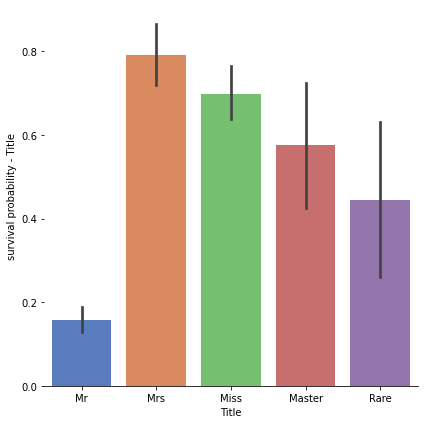

In [7]:
g = sns.catplot(x="Title",y="Survived",data=train_data,kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability - Title")

In [8]:
train_data['FamilySize'] = train_data.SibSp + train_data.Parch + 1
test_data['FamilySize'] = test_data.SibSp + test_data.Parch + 1
_FamilySize = train_data['FamilySize']

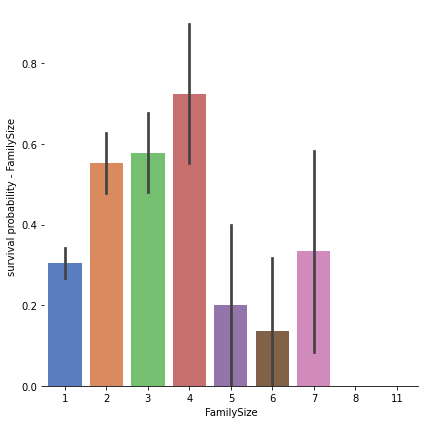

In [9]:
g = sns.catplot(x="FamilySize",y="Survived",data=train_data,kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability - FamilySize")

In [10]:
def familySize_to_cat(size):
    if size == 1: return "alone"
    if size >= 2 and size <= 4: return 'small'
    if size >= 5 and size <= 7: return 'medium'
    if size > 7 : return "large"

train_data['Fsize_cat'] = train_data.FamilySize.apply(familySize_to_cat)
test_data['Fsize_cat'] = test_data.FamilySize.apply(familySize_to_cat)

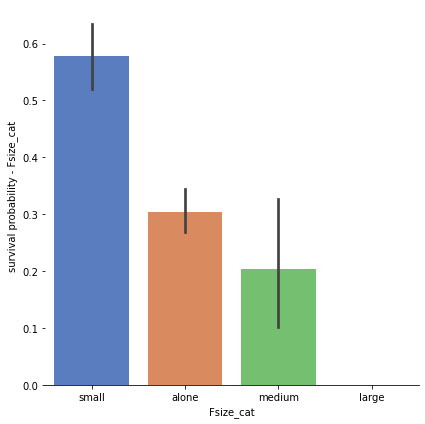

In [11]:
g = sns.catplot(x="Fsize_cat",y="Survived",data=train_data,kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability - Fsize_cat")

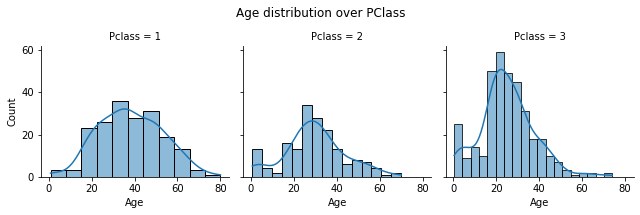

In [12]:
g = sns.FacetGrid(train_data, col="Pclass")
g = g.map(sns.histplot, "Age", kde=True)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Age distribution over PClass");

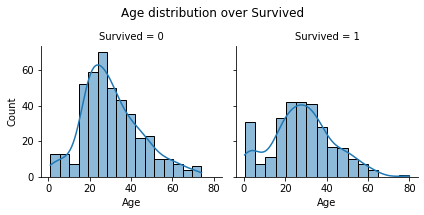

In [13]:
g = sns.FacetGrid(train_data,col="Survived")
g = g.map(sns.histplot, "Age", kde=True)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Age distribution over Survived");

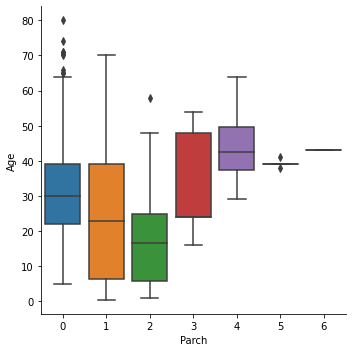

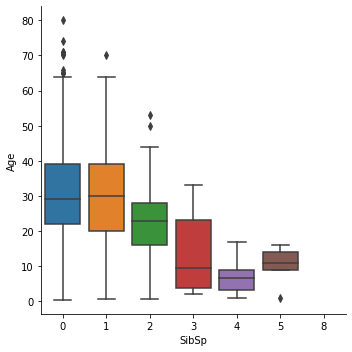

In [14]:
g = sns.catplot(y="Age",x="Parch", data=train_data,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=train_data,kind="box")

In [15]:
index_NaN_age = list(train_data["Age"][train_data["Age"].isnull()].index)
med_age = train_data.Age.median()
for i in index_NaN_age:
    pred_age = train_data["Age"][((train_data.SibSp == train_data.iloc[i]['SibSp']) & (train_data.Parch == train_data.iloc[i]['Parch']))].median()
    if np.isnan(pred_age):
        train_data.loc[train_data.index[i],'Age'] = med_age
    else:
        train_data.loc[train_data.index[i],'Age'] = pred_age

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [16]:
index_NaN_age_test = list(test_data["Age"][test_data["Age"].isnull()].index)
med_age = test_data.Age.median()
for i in index_NaN_age_test:
    pred_age = test_data["Age"][((test_data.SibSp == test_data.iloc[i]['SibSp']) & (test_data.Parch == test_data.iloc[i]['Parch']))].median()
    if np.isnan(pred_age):
        test_data.loc[test_data.index[i],'Age'] = med_age
    else:
        test_data.loc[test_data.index[i],'Age'] = pred_age

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [17]:
def cut_age(age):
    if age <= 15:
        return 'child'
    if age >= 60:
        return 'senior'
    return 'adult'

train_data['Age_Cat'] = train_data.Age.apply(cut_age) 
test_data['Age_Cat'] = test_data.Age.apply(cut_age) 

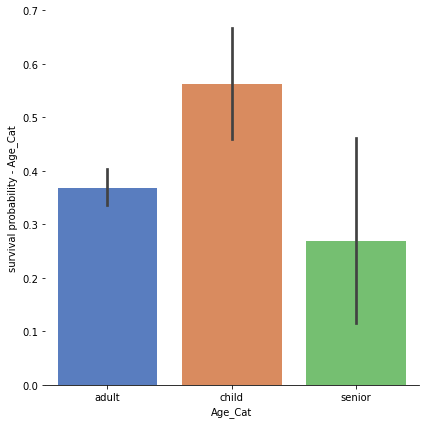

In [18]:
g = sns.catplot(x="Age_Cat",y="Survived",data=train_data,kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability - Age_Cat")

In [19]:
train_data['RealFare'] = train_data.Fare / train_data.FamilySize

index_zero_train = list(train_data['RealFare'][train_data['RealFare'] == 0].index)
for i in index_zero_train:
    med_fare = train_data['RealFare'][(train_data.Pclass == train_data.iloc[i]['Pclass'])].median()
    train_data.loc[train_data.index[i],'RealFare'] = med_age

In [20]:
test_data['RealFare'] = test_data.Fare / test_data.FamilySize

index_zero_train = list(test_data['RealFare'][test_data['RealFare'] == 0].index)
for i in index_zero_train:
    med_fare = test_data['RealFare'][(test_data.Pclass == test_data.iloc[i]['Pclass'])].median()
    test_data.loc[test_data.index[i],'RealFare'] = med_age

In [21]:
# skewed, I will apply log
train_data['RealFare'] = train_data['RealFare'].apply(lambda row: np.log(row) if row > 0 else 0)
test_data['RealFare'] = test_data['RealFare'].apply(lambda row: np.log(row) if row > 0 else 0)

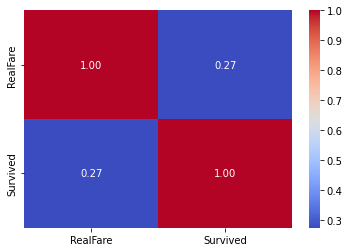

In [22]:
#numeric_features = ['RealFare', 'FamilySize']
numeric_features = ['RealFare']
num_to_check = [*numeric_features,'Survived']
g = sns.heatmap(train_data[[*numeric_features,'Survived']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [23]:
# MM works better in this case as StandardScaler
mm = MinMaxScaler()
#mm = StandardScaler()

#train
numeric_part_train = train_data[numeric_features]
transformed = mm.fit_transform(numeric_part_train)

for i,F in enumerate(numeric_features):
    train_data[F + '_scaled'] = transformed[:,i]

#test
numeric_part_test = test_data[numeric_features]
transformed = mm.fit_transform(numeric_part_test)

for i,F in enumerate(numeric_features):
    test_data[F + '_scaled'] = transformed[:,i]
    
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize,Fsize_cat,Age_Cat,RealFare,RealFare_scaled
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,Mr,2,small,adult,1.287854,0.190314
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,Mrs,2,small,adult,3.573515,0.564102
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,Miss,1,alone,adult,2.070022,0.318227
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,Mrs,2,small,adult,3.279030,0.515943
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,Mr,1,alone,adult,2.085672,0.320786


In [24]:
def get_deck(cabin):
    if cabin is np.nan or cabin.startswith('T'):
        return 'X'
    else:
        return cabin[0]
    
train_data.Cabin = train_data.Cabin.apply(get_deck)
test_data.Cabin = test_data.Cabin.apply(get_deck)
print(train_data.Cabin.value_counts(), len(train_data.Cabin.value_counts()))
print(test_data.Cabin.value_counts(), len(test_data.Cabin.value_counts()))

X    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Cabin, dtype: int64 8
X    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64 8


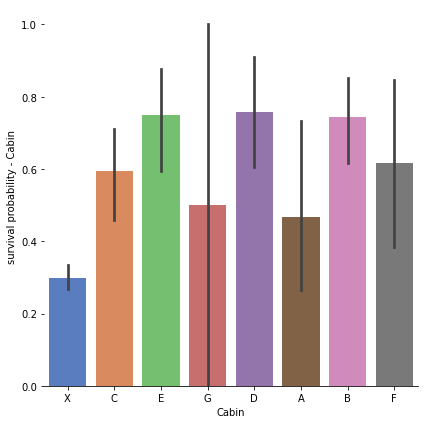

In [25]:
g = sns.catplot(x="Cabin",y="Survived",data=train_data,kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability - Cabin")

In [26]:
_Sex = train_data.Sex

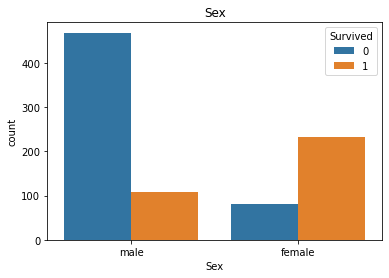

In [27]:
ax = sns.countplot(data = train_data, x = 'Sex', hue = "Survived");
ax.set_title("Sex");
train_data.Sex = train_data.Sex.apply(lambda row: 0 if row == "male" else 1)
test_data.Sex = test_data.Sex.apply(lambda row: 0 if row == "male" else 1)

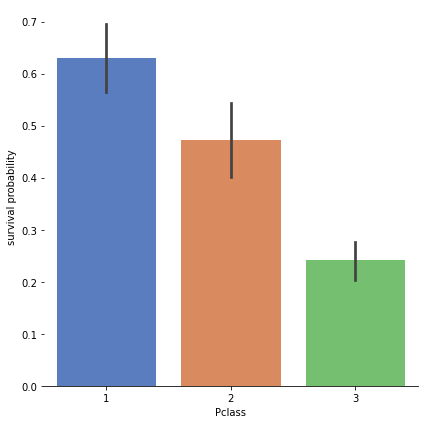

In [28]:
g = sns.catplot(x="Pclass",y="Survived",data=train_data,kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

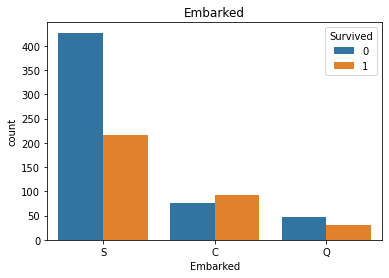

In [29]:
ax = sns.countplot(data = train_data, x = 'Embarked', hue = "Survived");
ax.set_title("Embarked");

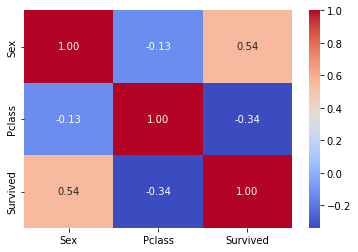

In [30]:
cat_features = ['Sex', 'Pclass']
num_to_check = [*cat_features,'Survived']
g = sns.heatmap(train_data[[*cat_features,'Survived']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [31]:
_Embarked = train_data.Embarked
_PClass = train_data.Pclass
_Cabin = train_data.Cabin
_Fare = train_data.RealFare
_Title = train_data.Title
_Age = train_data.Age_Cat
_Family = train_data.Fsize_cat

In [32]:
dummy_cols = ["Pclass", "Embarked", "Cabin", "Title", "Age_Cat",'Fsize_cat']
prefixes = ["PC", "EM", "CAB", "TT", "AG", "FAM"]

train_data = pd.get_dummies(train_data, columns = dummy_cols, prefix=prefixes)
test_data = pd.get_dummies(test_data, columns = dummy_cols, prefix=prefixes)

In [33]:
redundant_features = ['SibSp','Parch', "Name", "Fare", "Age", "FamilySize"]
train_data.drop(redundant_features, inplace = True, axis = 1)
test_data.drop(redundant_features, inplace = True, axis = 1)
#drop unscaled
train_data.drop(numeric_features, inplace = True, axis=1)
test_data.drop(numeric_features, inplace = True, axis=1)

In [34]:
train_data.head()

,PassengerId,Survived,Sex,RealFare_scaled,PC_1,PC_2,PC_3,EM_C,EM_Q,EM_S,...,TT_Mr,TT_Mrs,TT_Rare,AG_adult,AG_child,AG_senior,FAM_alone,FAM_large,FAM_medium,FAM_small
0,1,0,0,0.190314,0,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,1
1,2,1,1,0.564102,1,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
2,3,1,1,0.318227,0,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,4,1,1,0.515943,1,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,1
4,5,0,0,0.320786,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0


In [35]:
test_data.head()

,PassengerId,Sex,RealFare_scaled,PC_1,PC_2,PC_3,EM_C,EM_Q,EM_S,CAB_A,...,TT_Mr,TT_Mrs,TT_Rare,AG_adult,AG_child,AG_senior,FAM_alone,FAM_large,FAM_medium,FAM_small
0,892,0,0.369469,0,0,1,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
1,893,1,0.224922,0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1
2,894,0,0.407707,0,1,0,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0
3,895,0,0.387628,0,0,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
4,896,1,0.253147,0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1


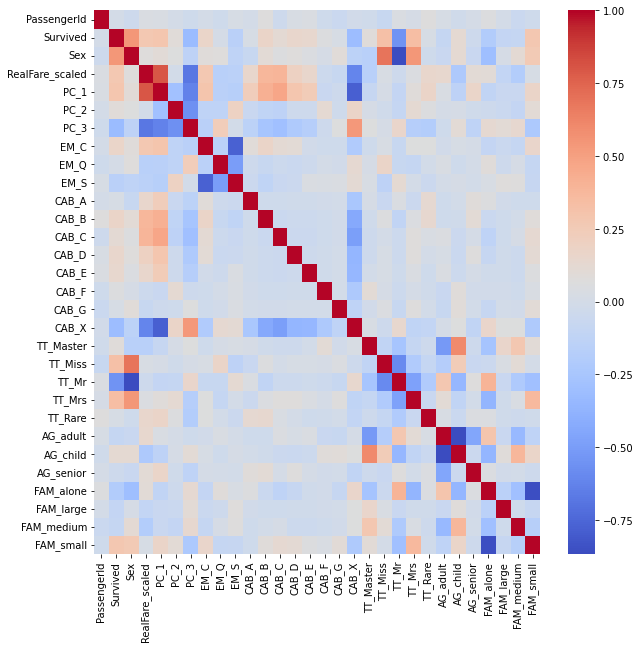

In [36]:
fig, ax = plt.subplots(figsize=(10,10))     
g = sns.heatmap(train_data.corr(),annot=False, cmap = "coolwarm")

In [37]:
y = train_data.Survived
X = train_data.drop(['Survived','PassengerId'], axis = 1)
TEST = test_data.drop('PassengerId', axis=1)

# reduced features we worse ...
#filter main features test
# main_features = ['TT_Mr', 'Sex', 'RealFare_scaled', 'PC_3', 'TT_Miss', 'FamilySize_scaled', 'TT_Mrs', 'CAB_X']
# X = X[main_features]
# TEST = TEST[main_features]
#end filter

print("X.shape",X.shape)
print("y.shape",y.shape)
print("TEST.shape", TEST.shape)

X.shape (891, 28)
y.shape (891,)
TEST.shape (418, 28)


In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42, stratify=y)

In [48]:

from keras import regularizers
dnn_model = Sequential()
n_cols = X.shape[1]
dnn_model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01),input_shape = (n_cols,))) 
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))) 
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(32, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(8, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(1, activation="sigmoid",kernel_regularizer=regularizers.l2(0.01)))              
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               3712      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

In [49]:
def plot_loss(loss,val_loss):
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_accuracy(acc,val_acc):
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


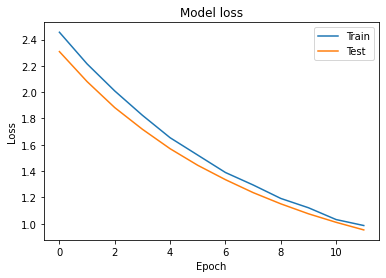

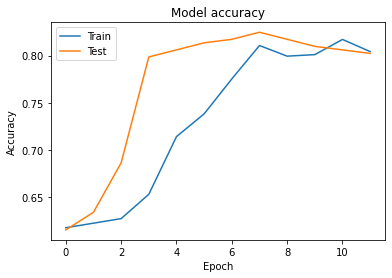

9/9 [==============================] - 0s 1ms/step - loss: 0.9534 - accuracy: 0.8022
Train accuracy: 82.50 %
Accuracy: 80.22 %
Overfit: 2.28 % 


In [50]:
import tensorflow 

adam = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.0)
dnn_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=4, monitor='val_accuracy')
#dnn_model.fit(X_train,y_train, validation_split = 0.3, callbacks=[early_stopping_monitor], epochs=200,batch_size=20, verbose=0)
dnn_model.fit(X_train,y_train, validation_data=(X_test,y_test), callbacks=[early_stopping_monitor], epochs=1000,batch_size=64, verbose=0)

plot_loss(dnn_model.history.history['loss'], dnn_model.history.history['val_loss'])
plot_accuracy(dnn_model.history.history['accuracy'], dnn_model.history.history['val_accuracy'])

_, train_dnn_accuracy = dnn_model.evaluate(X_train, y_train)
_, dnn_accuracy = dnn_model.evaluate(X_test, y_test)
print('Train accuracy: {:.2f} %'.format(train_dnn_accuracy*100))
print('Accuracy: {:.2f} %'.format(dnn_accuracy*100))
print('Overfit: {:.2f} % '.format((train_dnn_accuracy - dnn_accuracy)*100))

In [ ]:
PassengerIds = test_data.PassengerId.to_list()

# DNN
predicted = dnn_model.predict(TEST)
dnn_predictions = [int(np.rint(p)) for p in predicted]

In [ ]:
output = pd.DataFrame({'PassengerId': PassengerIds, 'Survived': dnn_predictions})

In [ ]:
output.to_csv('submission.csv', index=False)